In [151]:
import os
import lightning as L
import torch
import torchvision.transforms.functional as TF
from lightning import Trainer
from torch import nn
from torchvision.datasets import MNIST
from torch import Tensor
from typing import Tuple, Any
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from shared import overwrite_args_cli

torch.set_float32_matmul_precision('medium')

h = {  # hyperparameters
    'dataset': 'MNIST',  #'TOY_REGRESSION', 'RADIO',
    'dataset_path': '../data/',

    'num_views': 5,
    # 'loss': 'cross_entropy',  # 'cross_entropy', 'cross_entropy_with_distinct_path_regularization',
    'alpha': 0.1,

    'in_channels': 1,
    'latent_dims': [32, 64],
    'latent_strides': [2, 2],
    'latent_kernel_sizes': [3, 3],
    'num_classes': 10,

    'epochs': 2,
    'learning_rate': 1e-3,
    'checkpoint_path': './saved_models',
    'batch_size': 32,
    'num_workers': 4,

    'limit_train_batches': 1.0,
    'limit_val_batches': 1.0,
    'limit_test_batches': 1.0,

    'use_wandb': False,

    'wandb_project': 'uncertainty',
    'wandb_entity': 'oBoii',
    'wandb_name': 'radio',

    'train': True,  # Set this to false if you only want to evaluate the model
    'fast_dev_run': True,
    'overfit_batches': 0.0
}

h = overwrite_args_cli(h)
# assert h['loss'] in ['cross_entropy', 'cross_entropy_with_distinct_path_regularization']

In [152]:
class Loss(L.LightningModule):
    def __init__(self, alpha: float):
        super(Loss, self).__init__()
        assert 0.0 <= alpha <= 1.0, f"Alpha must be in [0, 1], got {alpha}."

        self.cross_entropy = nn.CrossEntropyLoss()
        self.alpha = alpha

    def forward(self, y_hat: Tensor, y: Tensor, latent_representations: list):
        # reshape to (batch * nb_views, num_classes)
        y_hat = y_hat.view(-1, y_hat.size(2))
        y = y.reshape(-1)

        if self.alpha == 1.0:
            return self.cross_entropy(y_hat, y)
        else:
            return (
                    self.alpha * self.cross_entropy(y_hat, y) +
                    (1 - self.alpha) * self.distinct_path_regularization(latent_representations))

        # return (self.cross_entropy(y_hat, y) +
        #         self.distinct_path_regularization(latent_representations))

    def distinct_path_regularization(self, latent_representations):
        """Compute the regularization term to penalize similar representations.
        In: List of latent representations of shape (batch, nb_views, C, H, W)
        Out: Scalar
        """
        reg_loss = 0.0
        for l in latent_representations:
            assert l.dim() == 5, f"Latent representation shape is {l.shape}, expected 5 dimensions."
            # Compute pairwise distances between views
            batch, nb_views, *dims = l.shape
            l = l.view(batch, nb_views, -1)  # Flatten spatial dimensions
            
            distances = torch.cdist(l, l, p=2)  # Pairwise L2 distances
            reg_loss += distances.mean()
        return reg_loss

In [153]:
class Classifier(L.LightningModule):
    def __init__(self, in_channels, latent_dims: list, latent_strides: list, latent_kernel_sizes: list,
                 num_classes: int, loss: Loss):
        super(Classifier, self).__init__()

        assert callable(loss), f"Loss must be a callable function, got {loss}."

        self.latent_dims = latent_dims
        self.loss = loss

        # Encoder layers. Each layer will be a reparameterization layer
        layers = []
        for dim, stride, kernel_size in zip(latent_dims, latent_strides, latent_kernel_sizes):
            layers.append(nn.Conv2d(in_channels, dim, kernel_size, stride))
            layers.append(nn.BatchNorm2d(dim))
            in_channels = dim

        self.layers = nn.ModuleList(layers)
        self.fc = nn.Linear(latent_dims[-1], num_classes)

    def forward(self, x: Tensor):
        # In: (batch, nb_views, C, H, W)
        # Out: (batch, nb_views, num_classes), latent_representations
        assert x.dim() == 5, f"Input shape is {x.shape}, expected 5 dimensions. (batch, nb_views, C, H, W)"
        return self.forward_multiple(x)

    def forward_single(self, x):
        # (batch, C, H, W)
        assert x.dim() == 4, f"Input shape is {x.shape}, expected 4 dimensions."
        latent_representations = []
        for layer in self.layers:
            x = layer(x)
            if isinstance(layer, nn.BatchNorm2d):
                x = nn.functional.relu(x)
            latent_representations.append(x)

        # average pooling
        x = nn.functional.avg_pool2d(x, x.size()[2:]).view(x.size(0), -1)
        x = self.fc(x)
        return x, latent_representations

    def forward_multiple(self, x):
        """Returns the predictions and latent representations of all views of the input."""
        # in: (batch, nb_views, C, H, W)
        # out: (batch, nb_views, num_classes), latent_representations

        # (batch, nb_views, C, H, W)
        assert x.dim() == 5, f"Input shape is {x.shape}, expected 5 dimensions."

        batch, nb_views, c, h, w = x.shape
        x = x.view(-1, c, h, w)  # (batch * nb_views, C, H, W)
        x, latent_representations = self.forward_single(x)
        x = x.view(batch, nb_views, -1)  # (batch, nb_views, num_classes)

        # Reshape latent representations
        latent_representations = [l.view(batch, nb_views, *l.shape[1:]) for l in latent_representations]
        return x, latent_representations

    def training_step(self, batch, batch_idx):
        x, y = batch  # x: (batch, nb_views, C, H, W), y: (batch)
        y = y.unsqueeze(1).expand(-1, x.size(1))  # (batch, nb_views)
        y_hat, latent_representations = self(x)  # (batch, nb_views, num_classes)

        loss = self.loss(y_hat, y, latent_representations)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.unsqueeze(1).expand(-1, x.size(1))  # (batch, nb_views)

        y_hat, latent_representations = self(x)

        loss = self.loss(y_hat, y, latent_representations)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.unsqueeze(1).expand(-1, x.size(1))  # (batch, nb_views)

        y_hat, latent_representations = self(x)

        loss = self.loss(y_hat, y, latent_representations)

        # torch.Size([32, 5, 10]) torch.Size([32, 5])
        # print(y_hat.shape, y.shape)
        # acc = (y_hat.argmax(dim=1) == y).float().mean()
        y_hat_mean = y_hat.mean(dim=1)
        acc = (y_hat_mean.argmax(dim=1) == y[:, 0]).float().mean()

        self.log('test_acc', acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=h['learning_rate'])

    def save(self) -> None:
        os.makedirs(h['checkpoint_path'], exist_ok=True)
        torch.save(self.state_dict(), os.path.join(h['checkpoint_path'], 'model.pth'))

    def load(self) -> 'SimpleNet':
        self.load_state_dict(torch.load(os.path.join(h['checkpoint_path'], 'model.pth')))
        self.eval()
        return self


def subsample(x: torch.Tensor, downscale_factor=2, noise_factor=0.05):
    assert x.dim() == 3  # (C, H, W)

    # Downsample using average pooling
    x = F.avg_pool2d(x, kernel_size=downscale_factor)

    # Introduce small random noise
    noise = torch.randn_like(x) * noise_factor
    x = x + noise

    # Clip values to stay within the valid range (e.g., for MNIST this is [0, 1])
    x = torch.clamp(x, 0.0, 1.0)

    return x


def subsample_with_random_stride(x: torch.Tensor, downscale_factor=2, max_offset=1):
    assert x.dim() == 3  # (C, H, W)

    # Randomly shift the starting point of the pooling window
    offset_h = torch.randint(0, max_offset + 1, (1,)).item()
    offset_w = torch.randint(0, max_offset + 1, (1,)).item()

    # Apply padding to ensure pooling still works after shifting
    x = F.pad(x, (offset_w, 0, offset_h, 0), mode='reflect')

    # Downsample using average pooling
    x = F.avg_pool2d(x, kernel_size=downscale_factor, stride=downscale_factor)

    return x


def subsample_with_patch_dropout(x: torch.Tensor, patch_size=2, dropout_prob=0.2):
    assert x.dim() == 3  # (C, H, W)

    # Divide the image into patches and randomly drop some
    c, h, w = x.size()
    patches_per_dim = h // patch_size
    mask = torch.rand(patches_per_dim, patches_per_dim) > dropout_prob

    # Reshape mask to match image resolution
    mask = mask.repeat_interleave(patch_size, dim=0).repeat_interleave(patch_size, dim=1)
    mask = mask.unsqueeze(0).expand(c, -1, -1)  # expand to channel dimension

    # Apply the mask (dropout)
    x = x * mask

    # Downsample after patch dropout
    x = F.avg_pool2d(x, kernel_size=patch_size)

    return x


def subsample_with_random_transform(x: torch.Tensor, downscale_factor=2):
    assert x.dim() == 3  # (C, H, W)

    # Random affine transformations (rotation, translation, scaling)
    angle = torch.randn(1).item() * 45  # Random rotation (-10 to 10 degrees)
    translate = [torch.randint(-2, 3, (1,)).item(), torch.randint(-2, 3, (1,)).item()]
    scale = 1.0 + torch.randn(1).item() * 0.1  # Scale within [0.9, 1.1]

    # Apply transformations (converted to PIL Image for easy manipulation)
    x_pil = TF.to_pil_image(x.squeeze(0))  # Remove channel dim for MNIST (assumed grayscale)
    x_pil = TF.affine(x_pil, angle=angle, translate=translate, scale=scale, shear=0)

    # Convert back to tensor and add channel dim again
    x = TF.to_tensor(x_pil).unsqueeze(0)

    # Downsample using average pooling
    x = F.avg_pool2d(x, kernel_size=downscale_factor)

    # Remove channel dimension for imshow compatibility
    x = x.squeeze(0)

    return x


def subsample_with_pixel_swapping(x: torch.Tensor, swap_prob=0.1, downscale_factor=2):
    assert x.dim() == 3  # (C, H, W)

    # Generate a mask for swapping pixels
    c, h, w = x.size()
    swap_mask = torch.rand(h, w) < swap_prob

    # Add channel dimension to the mask
    swap_mask = swap_mask.unsqueeze(0).expand(c, -1, -1)

    # Shift the image by one pixel in a random direction and swap pixels according to the mask
    shift_direction = torch.randint(0, 4, (1,)).item()  # Randomly pick direction: 0=up, 1=down, 2=left, 3=right
    if shift_direction == 0:
        x_shifted = F.pad(x[:, 1:, :], (0, 0, 0, 1), mode='reflect')
    elif shift_direction == 1:
        x_shifted = F.pad(x[:, :-1, :], (0, 0, 1, 0), mode='reflect')
    elif shift_direction == 2:
        x_shifted = F.pad(x[:, :, 1:], (0, 1, 0, 0), mode='reflect')
    else:
        x_shifted = F.pad(x[:, :, :-1], (1, 0, 0, 0), mode='reflect')

    x[swap_mask] = x_shifted[swap_mask]

    # Downsample after swapping
    x = F.avg_pool2d(x, kernel_size=downscale_factor)

    return x


def rnd_subsample_method(x: torch.Tensor):
    return subsample_with_random_transform(x)
    # methods = [subsample,
    #            subsample_with_random_stride,
    #            subsample_with_patch_dropout,
    #            subsample_with_random_transform,
    #            subsample_with_pixel_swapping
    #            ]
    # return methods[torch.randint(0, len(methods), (1,)).item()](x)


def create_multiple_views(x: torch.Tensor, num_views: int, transformation: callable):
    return torch.stack([transformation(x) for _ in range(num_views)], dim=0)


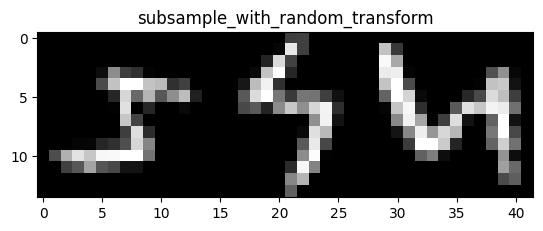

In [154]:
def show_transformations():
    # dispay the different subsampling methods, same image repeated 3 times
    transform = transforms.Compose([transforms.ToTensor()])  #rnd_subsample_method])
    mnist_train = MNIST(h['dataset_path'], train=True, download=True, transform=transform)

    methods = [
        # subsample,
        #        subsample_with_random_stride,
        #        subsample_with_patch_dropout,
        subsample_with_random_transform,
        # subsample_with_pixel_swapping
    ]
    x, y = mnist_train[0]
    for method in methods:
        # create 3 images and display them side by side
        imgs = [method(x) for _ in range(3)]
        imgs = torch.cat(imgs, dim=2)
        plt.imshow(imgs.squeeze(0), cmap='gray')
        plt.title(method.__name__)
        plt.show()


show_transformations()

In [155]:
def data_loaders(transformations: list):
    transform = transforms.Compose([transforms.ToTensor()] + transformations)
    mnist_train = MNIST(h['dataset_path'], train=True, download=True, transform=transform)
    mnist_val = MNIST(h['dataset_path'], train=False, download=True, transform=transform)

    train_loader = DataLoader(mnist_train, batch_size=h['batch_size'], shuffle=True)
    val_loader = DataLoader(mnist_val, batch_size=h['batch_size'], shuffle=False)
    return train_loader, val_loader


train_loader, val_loader = data_loaders(
    [lambda _: create_multiple_views(_, h['num_views'], subsample_with_random_transform)])
# train_loader, val_loader = data_loaders([subsample_with_random_transform])

c = Classifier(
    in_channels=h['in_channels'],
    latent_dims=h['latent_dims'],
    latent_strides=h['latent_strides'],
    latent_kernel_sizes=h['latent_kernel_sizes'],
    num_classes=h['num_classes'],
    loss=Loss(h['alpha'])
)

trainer = Trainer(max_epochs=h['epochs'], fast_dev_run=h['fast_dev_run'], overfit_batches=h['overfit_batches'])

if h['train']:
    trainer.fit(c, train_loader, val_loader)

# Evaluate the model
results = trainer.test(c, val_loader)

# Print accuracy
print(f"Test Accuracy: {results[0]['test_acc']:.4f}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | loss   | Loss       | 0     
1 | layers | ModuleList | 19.0 K
2 | fc     | Linear     | 650   
--------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │          0.15625          │
└───────────────────────────┴───────────────────────────┘

Test Accuracy: 0.1562


In [156]:
def _variances_vs_accuracy_per_input_img(classifier: Classifier, batch: Tuple[Tensor, Tensor]) -> Tensor:
    """Returns tensor of shape (batch, 2),
    where the first column is the variance and the second column
    is 1 or 0 if the prediction is correct or not."""

    x, y = batch
    assert x.dim() == 5  # (batch, nb_views, C, H, W)

    # 1) per view, compute the predictions
    predictions, _ = classifier.forward_multiple(x)  # (batch_size, num_views, num_classes)
    assert len(predictions.shape) == 3, f"Predictions shape is {predictions.shape}, expected 3 dimensions."

    # 2) compute the variance of the predictions
    variance = predictions.var(dim=1)  # (batch_size, num_classes)
    average_variance = variance.mean(dim=1)  # (batch_size)

    # 3) get mean of the predictions and take argmax
    final_predictions = predictions.mean(dim=1).argmax(dim=1)  # (batch_size)

    # 4) compute the accuracy of the mode with the labels
    accuracy = (final_predictions == y)  # (batch_size)

    # 5) stack the variance and accuracy
    stack = torch.stack((average_variance, accuracy), dim=1)  # (batch_size, 2)
    return stack


def variances_vs_accuracy_per_input_img(classifier: Classifier, data_loader: DataLoader) -> Tensor:
    """Returns tensor of shape (batch, 2),
    where the first column is the variance and the second column
    is 1 or 0 if the prediction is correct or not."""

    classifier.eval()
    var_vs_accuracy = None
    for batch in data_loader:
        batch_var_vs_accuracy = _variances_vs_accuracy_per_input_img(classifier, batch)
        if var_vs_accuracy is None:
            var_vs_accuracy = batch_var_vs_accuracy
        else:
            var_vs_accuracy = torch.cat((var_vs_accuracy, batch_var_vs_accuracy), dim=0)

    return var_vs_accuracy


c.eval()
train, val = data_loaders([lambda _: create_multiple_views(_, h['num_views'], subsample_with_random_transform)])
res = variances_vs_accuracy_per_input_img(c,
                                          val)  # (batch_size, 2) where 1st column is variance and 2nd is 1 or 0 if the prediction is correct or not
print(res.shape)

torch.Size([10000, 2])


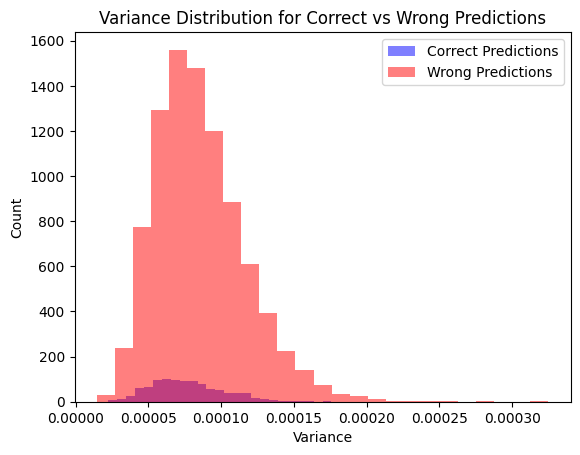

In [157]:
def distribution_variances_per_wrong_or_correct_prediction(var_vs_accuracy: Tensor):
    variances = var_vs_accuracy[:, 0].numpy()  # scalar values
    accuracies = var_vs_accuracy[:, 1].numpy()  # 0 or 1s

    fig, ax = plt.subplots()
    colors = ['blue', 'red']  # Colors for correct and wrong predictions
    labels = ['Correct Predictions', 'Wrong Predictions']

    for i, use_correct_predictions in enumerate([1., 0.]):
        indices = np.where(accuracies == use_correct_predictions)[0]
        variances_filtered = variances[indices]
        ax.hist(variances_filtered, bins=25, color=colors[i], alpha=0.5, label=labels[i])

    ax.set_xlabel("Variance")
    ax.set_ylabel("Count")
    ax.set_title("Variance Distribution for Correct vs Wrong Predictions")
    ax.legend()

    # Log the matplotlib figure to wandb
    # if options.use_wandb:
    #     wandb_section = get_wandb_audio_classific_key(opt, classifier_config)
    #     wandb.log({f"{wandb_section}_softmax/variance_distribution_combined": wandb.Image(fig)})

    plt.show()
    plt.close(fig)


distribution_variances_per_wrong_or_correct_prediction(res.detach())

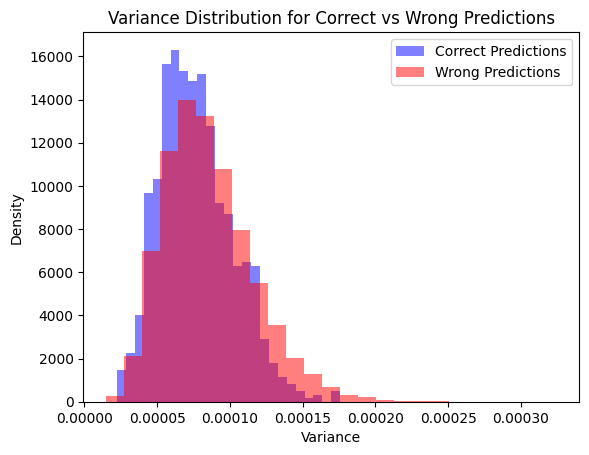

In [158]:
def distribution_variances_per_wrong_or_correct_prediction_normalized(var_vs_accuracy: Tensor):
    variances = var_vs_accuracy[:, 0].numpy()  # scalar values
    accuracies = var_vs_accuracy[:, 1].numpy()  # 0 or 1s

    fig, ax = plt.subplots()
    colors = ['blue', 'red']  # Colors for correct and wrong predictions
    labels = ['Correct Predictions', 'Wrong Predictions']

    for i, use_correct_predictions in enumerate([1., 0.]):
        indices = np.where(accuracies == use_correct_predictions)[0]
        variances_filtered = variances[indices]
        ax.hist(variances_filtered, bins=25, color=colors[i], alpha=0.5, label=labels[i], density=True)

    ax.set_xlabel("Variance")
    ax.set_ylabel("Density")
    ax.set_title("Variance Distribution for Correct vs Wrong Predictions")
    ax.legend()

    # Log the matplotlib figure to wandb
    # if options.use_wandb:
    #     wandb_section = get_wandb_audio_classific_key(opt, classifier_config)
    #     wandb.log({f"{wandb_section}_softmax/variance_distribution_combined": wandb.Image(fig)})

    plt.show()
    plt.close(fig)


distribution_variances_per_wrong_or_correct_prediction_normalized(res.detach())


In [159]:
# Function to add Gaussian noise
def add_gaussian_noise(images, noise_factor):
    noisy_images = images + noise_factor * torch.randn(*images.shape)
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images


# Function to compute model's uncertainty (e.g., softmax variance)
def compute_uncertainty(outputs):  # outputs: (batch_size, num_classes)
    # Softmax the output to get probabilities
    probs = F.softmax(outputs, dim=1)

    # Compute variance (uncertainty) across the class probabilities
    uncertainty = probs.var(dim=1)
    return uncertainty


def plot_uncertainty_vs_noise_level(model, test_loader):
    model.eval()

    # List to store noise levels and corresponding uncertainty values
    noise_levels = np.linspace(0, 1, 10)
    mean_uncertainties = []

    for noise_factor in noise_levels:
        all_uncertainties = []

        for images, _ in test_loader:
            noisy_images = add_gaussian_noise(images, noise_factor)
            with torch.no_grad():
                outputs = model(noisy_images)
                uncertainty = compute_uncertainty(outputs)
                all_uncertainties.append(uncertainty.mean().item())

        mean_uncertainties.append(np.mean(all_uncertainties))

    # Plotting the results
    plt.figure(figsize=(8, 6))
    plt.plot(noise_levels, mean_uncertainties, marker='o', linestyle='-')
    plt.title('Model Uncertainty under Distributional Shift (Gaussian Noise)')
    plt.xlabel('Noise Level (std dev of Gaussian noise)')
    plt.ylabel('Mean Uncertainty (Softmax Variance)')
    plt.grid(True)
    plt.show()


plot_uncertainty_vs_noise_level(c, val_loader)


AttributeError: 'tuple' object has no attribute 'softmax'